In [1]:
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm

# -----------------------------
# 0) Utility primitives
# -----------------------------

def prospect_value_vec(x, alpha_gain, beta_loss, lambda_loss):
    return np.where(
        x >= 0,
        x ** alpha_gain,
        -lambda_loss * ((-x) ** beta_loss)
    )

def utility_draws(C, H, W_next_draws, params):
    # habit term: keep C-H positive via small floor
    ch = np.maximum(C - H, 1e-12)
    u_c = (ch ** params["gamma"]) / params["gamma"]  # gamma typically < 0
    
    wealth_gap = W_next_draws - params["reference_level"]
    u_p = prospect_value_vec(
        wealth_gap,
        params["alpha_gain"],
        params["beta_loss"],
        params["lambda_loss"]
    )
    return u_c + params["theta"] * u_p


# -----------------------------
# 1) Firm side (expected + realised)
# -----------------------------

def mpk_expected(alpha_vec, mu_expect_vec, K_vec):
    # E[MPK] = alpha * E[A] * K^(alpha-1)
    return alpha_vec * mu_expect_vec * (K_vec ** (alpha_vec - 1))

def production(alpha_vec, A_real_vec, K_vec):
    # Y = A * K^alpha
    return A_real_vec * (K_vec ** alpha_vec)

def update_capital(K_vec, I_vec, delta_vec):
    return (1.0 - delta_vec) * K_vec + I_vec


# -----------------------------
# 2) Household pricing (simultaneous across all countries)
# -----------------------------

def household_pricing_and_weights(
    expected_returns_vec,   # vector length N, interpreted as expected risky return (MPK proxy)
    W_vec,                  # household wealth vector length N
    H_vec,                  # habit vector length N
    params,
    rng,
    allow_cross_border=True,
    n_draws=200
):
    """
    Returns:
      r_vec    : implied required returns (length N)
      Wmat     : weight matrix (N x N), Wmat[i,j] = share of i's investable wealth into asset j
                row sum <= 1, residual goes risk-free
    """

    expected_returns_vec = np.asarray(expected_returns_vec, float)
    W_vec = np.asarray(W_vec, float)
    H_vec = np.asarray(H_vec, float)

    sigma_vec = np.asarray(params["sigma_vec"], float)
    r_f = params["r_f"]
    c_rate = params["consumption_rate"]

    N = len(expected_returns_vec)

    # Common random numbers for stability/speed within this call
    Z = rng.normal(0.0, 1.0, size=(N, n_draws))
    R_draws = expected_returns_vec[:, None] + sigma_vec[:, None] * Z  # shape (N, n_draws)

    # Decision variables:
    # - Cross-border: optimise full Wmat (N*N)
    # - Closed: optimise diag only (N)
    if allow_cross_border:
        x0 = np.full(N * N, 0.2 / max(N, 1))
    else:
        x0 = np.full(N, 0.2)  # diagonal weights initial guess

    def unpack(x):
        if allow_cross_border:
            Wmat = x.reshape(N, N)
            Wmat = np.maximum(Wmat, 0.0)
            return Wmat
        else:
            wdiag = np.maximum(x, 0.0)
            Wmat = np.zeros((N, N))
            np.fill_diagonal(Wmat, wdiag)
            return Wmat

    def penalty(Wmat):
        pen = 0.0
        # rows must sum <= 1 (risk-free is residual)
        row_sums = Wmat.sum(axis=1)
        excess = np.maximum(row_sums - 1.0, 0.0)
        pen += 1e7 * np.sum(excess**2)
        # if closed, off-diagonals must be 0 (already by construction)
        return pen

    def objective(x):
        Wmat = unpack(x)
        pen = penalty(Wmat)
        if pen > 0:
            return pen

        # Average utility across households
        u_list = []

        for i in range(N):
            w_i = Wmat[i, :]
            w_rf = 1.0 - w_i.sum()

            W0 = W_vec[i]
            H0 = H_vec[i]
            C = c_rate * W0

            # Gross portfolio returns draws
            gross = np.dot(w_i, 1.0 + R_draws) + w_rf * (1.0 + r_f)

            W_next = (W0 - C) * gross  # dividends handled later in realised step
            u = utility_draws(C, H0, W_next, params)
            u_list.append(np.mean(u))

        return -float(np.mean(u_list))

    res = minimize(
        objective,
        x0,
        method="Nelder-Mead",
        options={"maxiter": params.get("maxiter_weights", 300), "disp": False}
    )

    Wmat = unpack(res.x)

    # Clean: enforce row sum <= 1 by scaling if needed
    row_sums = Wmat.sum(axis=1)
    for i in range(N):
        if row_sums[i] > 1.0:
            Wmat[i, :] = Wmat[i, :] / row_sums[i]

    # Pricing: required return = expected return - premium(demand, risk)
    # (simple but responsive: premium increases with total demand into each asset)
    gamma_eff = abs(params["gamma"]) + params["theta"] * params["lambda_loss"]
    col_demand = Wmat.sum(axis=0)  # total risky weight going into asset j
    premium = gamma_eff * (sigma_vec ** 2) * col_demand

    r_vec = expected_returns_vec - premium
    return r_vec, Wmat


# -----------------------------
# 3) Equilibrium in K-space (minimise MPK - (r+delta))
# -----------------------------

def equilibrium_objective_K(
    K_candidate,
    K_prev,
    alpha_vec,
    mu_expect_vec,
    delta_vec,
    W_vec,
    H_vec,
    params,
    rng,
    allow_cross_border,
    n_draws_pricing
):
    K_candidate = np.maximum(np.asarray(K_candidate, float), 1e-8)

    # Expected MPK under candidate capital
    MPK = mpk_expected(alpha_vec, mu_expect_vec, K_candidate)

    r_vec, _Wmat = household_pricing_and_weights(
        expected_returns_vec=MPK,
        W_vec=W_vec,
        H_vec=H_vec,
        params=params,
        rng=rng,
        allow_cross_border=allow_cross_border,
        n_draws=n_draws_pricing
    )

    err = MPK - (r_vec + delta_vec)
    return float(np.sum(err**2))


def solve_equilibrium_K_only(
    K_prev,
    alpha_vec,
    mu_expect_vec,
    delta_vec,
    W_vec,
    H_vec,
    params,
    rng,
    allow_cross_border=True,
    n_draws_pricing=200
):
    K_prev = np.maximum(np.asarray(K_prev, float), 1e-8)

    res = minimize(
        equilibrium_objective_K,
        K_prev,  # start from previous K
        args=(K_prev, alpha_vec, mu_expect_vec, delta_vec, W_vec, H_vec, params, rng, allow_cross_border, n_draws_pricing),
        method="Nelder-Mead",
        options={"maxiter": params.get("maxiter_K", 250), "disp": False}
    )

    K_star = np.maximum(res.x, 1e-8)
    MPK_star = mpk_expected(alpha_vec, mu_expect_vec, K_star)

    r_star, Wmat_star = household_pricing_and_weights(
        expected_returns_vec=MPK_star,
        W_vec=W_vec,
        H_vec=H_vec,
        params=params,
        rng=rng,
        allow_cross_border=allow_cross_border,
        n_draws=n_draws_pricing
    )

    return K_star, r_star, Wmat_star


# -----------------------------
# 4) One-year transition (realise shocks + update states)
# -----------------------------

def one_year_update(
    K_t, W_t, H_t,
    K_star, r_star, Wmat_star,
    alpha_vec, mu_bar_vec, sigma_A_vec, delta_vec,
    params,
    rng
):
    """
    Realise productivity shocks, output, dividends, realised equity returns, update wealth/habit/capital.
    """

    N = len(K_t)
    r_f = params["r_f"]
    c_rate = params["consumption_rate"]
    rho = params["rho"]

    # Investment needed to reach K_star (capital chosen in equilibrium step)
    I_t = K_star - (1.0 - delta_vec) * K_t

    # Productivity shock per country
    A_real = mu_bar_vec + rng.normal(0.0, sigma_A_vec, size=N)

    # Output
    Y = production(alpha_vec, A_real, K_star)

    # Dividends: simplest accounting
    # dividends = max(Y - I, 0), shortfall financed by issuance (implicitly)
    dividends = np.maximum(Y - I_t, 0.0)

    # Realised equity return proxy:
    # use realised MPK as risky return (simple, consistent with your MPK logic)
    R_real = mpk_expected(alpha_vec, A_real, K_star)  # realised MPK using A_real as level

    # Update households
    W_next = np.zeros(N)
    H_next = np.zeros(N)

    for i in range(N):
        C = c_rate * W_t[i]
        w_i = Wmat_star[i, :]
        w_rf = 1.0 - w_i.sum()

        # portfolio gross return
        gross = np.dot(w_i, (1.0 + R_real)) + w_rf * (1.0 + r_f)

        # add dividends proportionally to holdings of each asset (simple proportional allocation)
        # household i receives sum_j w_ij * dividends_j
        div_i = float(np.dot(w_i, dividends))

        W_next[i] = (W_t[i] - C) * gross + div_i
        H_next[i] = rho * H_t[i] + (1.0 - rho) * C

    # Capital becomes chosen capital
    K_next = K_star.copy()

    return K_next, W_next, H_next, dict(
        A_real=A_real, Y=Y, I=I_t, dividends=dividends, R_real=R_real
    )


# -----------------------------
# 5) Full simulation loop
# -----------------------------

def run_simulation(
    T,
    K0, W0, H0,
    alpha_vec, mu_bar_vec, sigma_A_vec, delta_vec,
    params,
    seed=42,
    allow_cross_border=True,
    n_draws_pricing=200,
    verbose=False
):
    rng = np.random.default_rng(seed)

    K = np.array(K0, float)
    W = np.array(W0, float)
    H = np.array(H0, float)

    hist = {
        "K": [], "W": [], "H": [],
        "r": [], "Wmat": [],
        "A": [], "Y": [], "I": [], "dividends": [], "R_real": []
    }

    for t in tqdm(range(T)):
        # Expectations (you can later make mu_expect time-varying; start with mu_bar)
        mu_expect = mu_bar_vec

        # 1) Equilibrium: choose K only, households price simultaneously => r
        K_star, r_star, Wmat_star = solve_equilibrium_K_only(
            K_prev=K,
            alpha_vec=alpha_vec,
            mu_expect_vec=mu_expect,
            delta_vec=delta_vec,
            W_vec=W,
            H_vec=H,
            params=params,
            rng=rng,
            allow_cross_border=allow_cross_border,
            n_draws_pricing=n_draws_pricing
        )

        # 2) Realise shocks + update states
        K, W, H, aux = one_year_update(
            K_t=K, W_t=W, H_t=H,
            K_star=K_star, r_star=r_star, Wmat_star=Wmat_star,
            alpha_vec=alpha_vec, mu_bar_vec=mu_bar_vec, sigma_A_vec=sigma_A_vec, delta_vec=delta_vec,
            params=params,
            rng=rng
        )

        # Store
        hist["K"].append(K.copy())
        hist["W"].append(W.copy())
        hist["H"].append(H.copy())
        hist["r"].append(r_star.copy())
        hist["Wmat"].append(Wmat_star.copy())

        hist["A"].append(aux["A_real"])
        hist["Y"].append(aux["Y"])
        hist["I"].append(aux["I"])
        hist["dividends"].append(aux["dividends"])
        hist["R_real"].append(aux["R_real"])

        if verbose:
            # report equilibrium error using expected MPK
            MPK_e = mpk_expected(alpha_vec, mu_expect, K)
            err = MPK_e - (r_star + delta_vec)
            print(f"t={t} max|MPK-(r+δ)|={np.max(np.abs(err)):.4e}")

    # convert list->array where useful
    for k in ["K","W","H","r","A","Y","I","dividends","R_real"]:
        hist[k] = np.array(hist[k])

    return hist


In [2]:
N = 10
T = 50

K0 = np.array([np.random.uniform(0.8, 1.2) for _ in range(N)])
W0 = np.array([100.0 for _ in range(N)])
H0 = np.array([10.0 for _ in range(N)])

alpha_vec = np.array([np.random.uniform(0.25, 0.35) for _ in range(N)])
mu_bar_vec = np.array([np.random.uniform(0.90, 1.10) for _ in range(N)])
sigma_A_vec = np.array([0.05 for _ in range(N)])     # productivity shock std per country
delta_vec = np.array([0.05 for _ in range(N)])

params = {
    "consumption_rate": 0.05,
    "rho": 0.8,
    "gamma": -2.0,
    "theta": 0.5,
    "alpha_gain": 0.5,
    "beta_loss": 0.5,
    "lambda_loss": 2.0,
    "reference_level": 100.0,
    "r_f": 0.02,
    "sigma_vec": np.array([0.10 for _ in range(N)]),
    "maxiter_weights": 220,
    "maxiter_K": 180
}

# Open
hist_open = run_simulation(
    T, K0, W0, H0,
    alpha_vec, mu_bar_vec, sigma_A_vec, delta_vec,
    params,
    seed=42,
    allow_cross_border=True,
    n_draws_pricing=150,
    verbose=False
)

# Closed (domestic-only, risk-free allowed)
hist_closed = run_simulation(
    T, K0, W0, H0,
    alpha_vec, mu_bar_vec, sigma_A_vec, delta_vec,
    params,
    seed=42,
    allow_cross_border=False,
    n_draws_pricing=150,
    verbose=False
)


  0%|          | 0/50 [00:00<?, ?it/s]/var/folders/_x/74827dzs033cwdj2j4gch59r0000gn/T/ipykernel_50953/887387387.py:13: RuntimeWarning: invalid value encountered in sqrt
  -lambda_loss * ((-x) ** beta_loss)
  2%|▏         | 1/50 [00:52<42:38, 52.21s/it]


KeyboardInterrupt: 

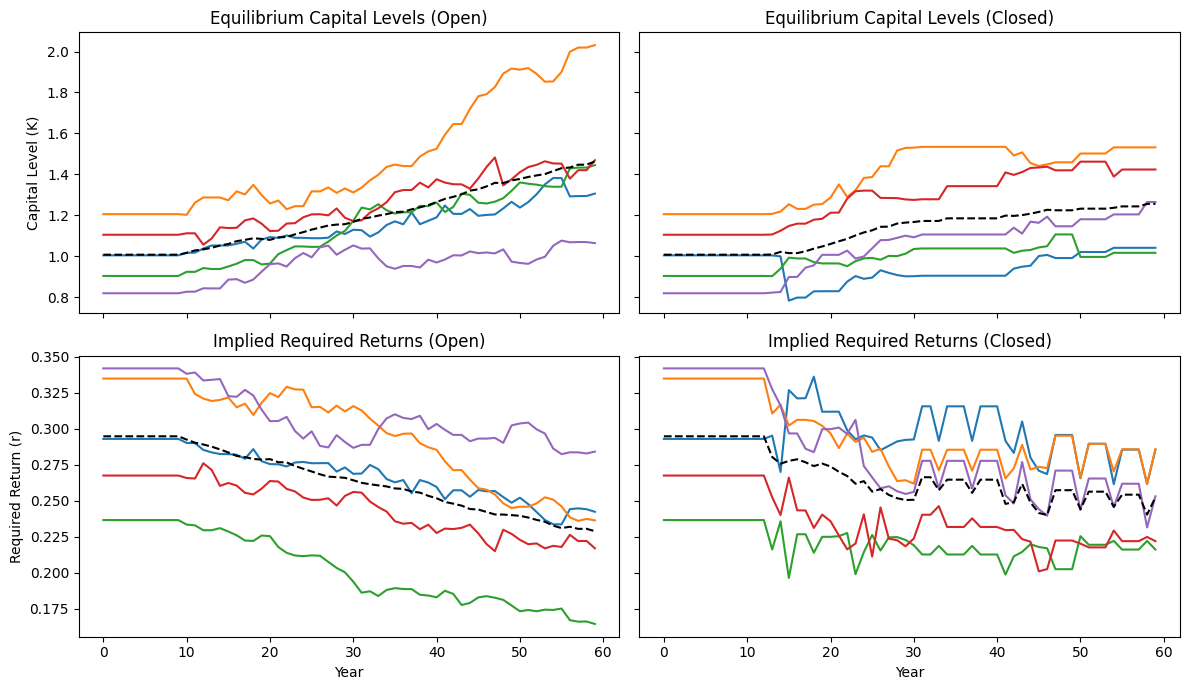

In [ ]:
# Plot the r and K for open vs closed
# row 1: K open vs closed (2 columns, shared x and y axis)
# row 2: r open vs closed (2 columns, shared x and y axis)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey='row')

# K plots
for i in range(N):
    axes[0, 0].plot(hist_open["K"][:, i])
    axes[0, 1].plot(hist_closed["K"][:, i])
# Plot average
axes[0, 0].plot(hist_open["K"].mean(axis=1), color='black', linestyle='--', label='Average')
axes[0, 1].plot(hist_closed["K"].mean(axis=1), color='black', linestyle='--', label='Average')

axes[0, 0].set_title("Equilibrium Capital Levels (Open)")
axes[0, 1].set_title("Equilibrium Capital Levels (Closed)")
axes[0, 0].set_ylabel("Capital Level (K)")

# r plots
for i in range(N):
    axes[1, 0].plot(hist_open["r"][:, i])
    axes[1, 1].plot(hist_closed["r"][:, i])
# Plot average
axes[1, 0].plot(hist_open["r"].mean(axis=1), color='black', linestyle='--', label='Average')
axes[1, 1].plot(hist_closed["r"].mean(axis=1), color='black', linestyle='--', label='Average')

axes[1, 0].set_title("Implied Required Returns (Open)")
axes[1, 1].set_title("Implied Required Returns (Closed)")
axes[1, 0].set_xlabel("Year")
axes[1, 1].set_xlabel("Year")
axes[1, 0].set_ylabel("Required Return (r)")
plt.tight_layout()
plt.show()

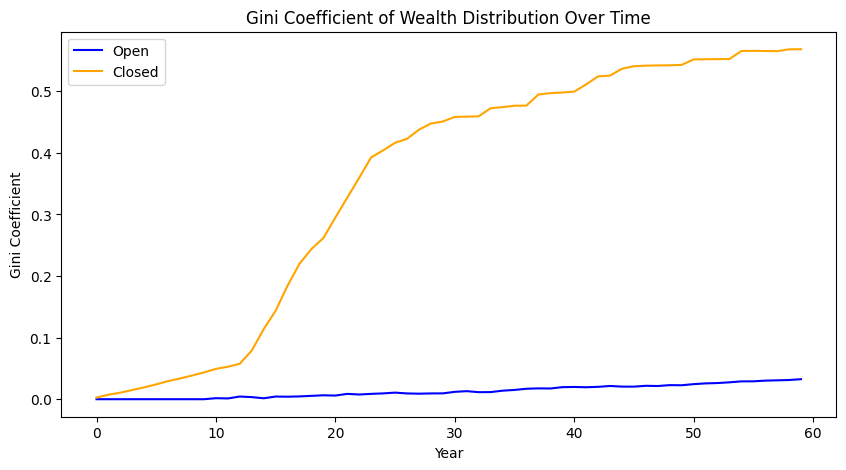

In [ ]:
# Get gini coefficients of wealth distirbution
# across the countries capital over time. 
# Get per year

def gini_coefficient(x):
    # Compute Gini coefficient of array x
    sorted_x = np.sort(x)
    n = len(x)
    cumulative = np.cumsum(sorted_x)
    gini = (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n
    return gini

gini_open = [gini_coefficient(hist_open["W"][t]) for t in range(T)]
gini_closed = [gini_coefficient(hist_closed["W"][t]) for t in range(T)]

# plot on same graph
plt.figure(figsize=(10, 5))
plt.plot(gini_open, label="Open", color='blue')
plt.plot(gini_closed, label="Closed", color='orange')
plt.title("Gini Coefficient of Wealth Distribution Over Time")
plt.xlabel("Year")
plt.ylabel("Gini Coefficient")
plt.legend()
plt.show()